#6.8300 Final Project
## Catherine Mei and Linette Kunin

In [ ]:
# store as npy file
# plot in matplotlib
# is 2D array
# convert to pytorch tensor

# matplotlib as heatmap to try to visualize
# spectrogram will be our label
# spectrogram have to be scaled from 1 to -1
# make sure to normalize the data

# Enough for project

# coordconv

# go from vector to spectrogram possibly with either __ * f *times or convolutional decoder and transpose convlution

### Imports

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import os
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import imageio
import matplotlib.pyplot as plt
import time
import copy
from tqdm import tqdm
import torch.optim as optim
import random

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print("Using the GPU!")
else:
    print("WARNING: Could not find GPU! Using CPU only")
    print("You may want to try to use the GPU in Google Colab by clicking in:")
    print("Runtime > Change Runtime type > Hardware accelerator > GPU.")

Using the GPU!


### Import Data

In [ ]:
use_gdrive = True

In [ ]:
if use_gdrive:
  from google.colab import drive
  drive.mount('/content/drive')

  data_dir = "/content/drive/MyDrive/6.8300FinalProject"
else:
  data_dir = "./data"

downloads_dir = data_dir + '/downloads'
datasets_dir = data_dir + '/vis-data-256'
processed_data_dir = data_dir + '/vis-data-processed'
models_dir = data_dir + '/models'
pretrained_models = data_dir + '/pretrained_models'
q2c_data_dir = data_dir + '/q2c_data'

Mounted at /content/drive


In [ ]:
# vis_low_res = datasets_dir + '/vis-data-256.zip'
# vis_sound_features = datasets_dir + '/vis-sfs.zip'

### Create Class for Dataset

In [ ]:
class VisData(Dataset):
  def __init__(self, split = 'train', mode='image'):
    self.image_transforms = transforms.Compose([
          transforms.ToPILImage(),
          transforms.RandomHorizontalFlip(0.5),
          transforms.RandomVerticalFlip(0.5),
          transforms.ToTensor(),
        ])

    self.imageToTensor = transforms.Compose([transforms.ToPILImage(), transforms.Grayscale(1), transforms.ToTensor()])
    self.ignoreFiles = {"2015-02-21-17-48-19", "2015-03-28-20-13-18"}
    self.split = split
    self.mode = mode

    self.inputs, self.labels = self.get_dataset_input_label()
    self.n = len(self.labels)

  def __getitem__(self, index):
    return self.inputs[index], self.labels[index]

  def __len__(self):
    return self.n

  def get_dataset_input_label(self):
    data_split = []

    input = []
    material_label = []

    # get videos in dataset depending on train or test split
    data_ids_path = ""
    if self.split in {'train', 'val'}:
      data_ids_path = processed_data_dir + "/train.txt"
    elif self.split == "test":
      data_ids_path = processed_data_dir + "/test.txt"

    with open(data_ids_path, 'r') as f:
        all_ids = f.read()
        all_ids = all_ids.split("\n")
        data_split = [id for id in all_ids if len(id)] # all of the video ids that are part of this dataset split

    file_count = 0
    # for each file id, get all the hits in that file
    for file_id in data_split:
      file_count+=1
      if file_id in self.ignoreFiles:
        continue
      video_id_path = processed_data_dir + "/" + file_id
      filenames = os.listdir(video_id_path)
      num_hits = len([i for i in filter(lambda x: x.endswith(".png"), filenames)])

      # every_x_hits = random.randint(0, 1)
      every_x_hits = 0
      for i in range(num_hits):
        # only include half of the hits
        if i % 20 != every_x_hits:
          continue

        try:
          if self.mode == "image":
            input_in = self.load_image_with_id(file_id, i)
          elif self.mode == "sound":
            input_in = self.get_spectrogram_for_hit(file_id, i)
          elif self.mode == "fc_agg":
            input_in = self.get_stacked_image_spec(file_id, i)
          else:
            raise TypeError()


          material = self.get_material_label(file_id, i)

          input.append(input_in)
          material_label.append(material)

        except:
          print("skipped: ", file_id, i)
          continue

      if file_count %50 ==0:
        print("loaded: ", file_count)

    return input, material_label

  def get_stacked_image_spec(self, file_id, i):
    img = self.load_image_with_id(file_id, i)
    spec = torch.tensor(self.get_spectrogram_for_hit(file_id, i))
    return [img, spec]

  def load_image_with_id(self, file_id, index, apply_transforms = True):
    file_path = processed_data_dir + "/" + file_id + "/" + file_id + "_image_" + str(index) + ".png"
    img = imageio.imread(file_path, pilmode='RGB')
    if apply_transforms:
      img = self.image_transforms(img)
    # img = self.transforms(img)
    return img

  def get_material_label(self, file_id, index):
    file_path = processed_data_dir + "/" + file_id + "/" + file_id + "_labels_" + str(index) + ".txt"
    with open(file_path, 'r') as f:
      input = f.read()
      lines = input.split("\n")
      label = int(lines[0])
    return label

  def get_spectrogram_for_hit(self, file_id, index):
    file_path = processed_data_dir + "/" + file_id + "/" + file_id + "_spectrogram_" + str(index) + ".npy"
    spectrogram = np.load(file_path)
    spectrogram = np.transpose(np.repeat(spectrogram[:, :, np.newaxis], 3, axis=2), (2,0,1))
    return spectrogram


In [ ]:
# data_stats_train = VisData(split = 'train', mode = 'image')

In [ ]:
# image, label = data_stats_train[0]
# plt.imshow(np.transpose(image, (1,2,0)))

### Model Initialization

In [ ]:
def initialize_model(model_name, num_classes, resume_from = None, use_pretrained = False, mode = None):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    # The model (nn.Module) to return
    model_ft = None
    # The input image is expected to be (input_size, input_size)
    input_size = 0

    # By default, all parameters will be trained (useful when you're starting from scratch)
    # Within this function you can set .requires_grad = False for various parameters, if you
    # don't want to learn them

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "resnet50":
        """ Resnet50
        """
        model_ft = models.resnet50(pretrained=use_pretrained)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    else:
        raise Exception("Invalid model name!")

    if resume_from is not None:
        print("Loading weights from %s" % resume_from)
        model_ft.load_state_dict(torch.load(resume_from))

    return model_ft, input_size

## Dataloader

In [ ]:
def get_image_transforms():
    # How to transform the image when you are loading them.
    # you'll likely want to mess with the transforms on the training set.

    # We convert the image to a [C,H,W] tensor, then normalize it to values with a given mean/stdev. These normalization constants
    # are derived from the mean/stdev of the ImageNet training set which was used to pretrain our models.

    transform = transforms.Compose([
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
    return transform

def get_dataloaders(input_size, batch_size, mode, shuffle = True, transform=get_image_transforms()):
    data_transforms = {
        # 'train': VisData(split = "train", mode = mode),
        # 'val': VisData(split = "val", mode = mode),
        'test': VisData(split = "test", mode = mode)
    }
    # Create training, validation and test dataloaders
    # Never shuffle the test set
    dataloaders_dict = {x: DataLoader(data_transforms[x], batch_size=batch_size, shuffle=False if x != 'train' else shuffle, num_workers=4) for x in data_transforms.keys()}
    return dataloaders_dict

## Train Model

In [ ]:
def train_model(model, dataloaders, criterion, optimizer, save_dir = None, save_all_epochs=False, num_epochs=25, eval_mode = "multiclass", mode = None):
    '''
    model: The NN to train
    dataloaders: A dictionary containing at least the keys
                 'train','val' that maps to Pytorch data loaders for the dataset
    criterion: The Loss function
    optimizer: The algorithm to update weights
               (Variations on gradient descent)
    num_epochs: How many epochs to train for
    save_dir: Where to save the best model weights that are found,
              as they are found. Will save to save_dir/weights_best.pt
              Using None will not write anything to disk
    save_all_epochs: Whether to save weights for ALL epochs, not just the best
                     validation error epoch. Will save to save_dir/weights_e{#}.pt
    '''
    since = time.time()

    val_acc_history = []
    train_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            # TQDM has nice progress bars
            for inputs, labels in tqdm(dataloaders[phase]):
                if eval_mode == 'singleclass':
                  labels = labels.type(torch.FloatTensor)

                if mode == "fcagg":
                  input0, input1 = inputs
                  input0 = input0.to(device)
                  input1 = input1.to(device)
                else:
                  inputs = inputs.to(device)

                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    if mode == "fcagg":
                      outputs = model(input0, input1)
                    else:
                      outputs = model(inputs)

                    outputs = outputs.to(device)
                    loss = criterion(outputs, labels)

                    # torch.max outputs the maximum value, and its index
                    # Since the input is batched, we take the max along axis 1
                    # (the meaningful outputs)
                    if eval_mode == "multiclass":
                      _, preds = torch.max(outputs, 1)
                    elif eval_mode == "multilabel":
                      preds = torch.sigmoid(outputs > 0.5).long()
                    elif eval_mode == 'singleclass':
                      preds = torch.sigmoid(outputs > 0.5).long()

                    # backprop + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                if mode == "fcagg":
                  running_loss +=loss.item() * input0.size(0) + loss.item() * input1.size(0)
                else:
                  running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)


            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'train':
                train_acc_history.append(epoch_acc)
            if phase == 'val':
                val_acc_history.append(epoch_acc)
            if save_all_epochs:
                #torch.save(model.state_dict(), os.path.join(save_dir, f'{mode}_weights_{epoch}.pt'))
                pass

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # save and load best model weights
    torch.save(best_model_wts, os.path.join(save_dir, mode + '_weights_best_val_acc.pt'))
    torch.save(model.state_dict(), os.path.join(save_dir, mode + '_weights_last.pt'.format(epoch)))
    model.load_state_dict(best_model_wts)

    with open(os.path.join(save_dir, mode + '_train_history.txt'), 'w') as f:
      for i in range(num_epochs):
        f.write(str(train_acc_history[i])+'\n')

    with open(os.path.join(save_dir, mode + '_val_history.txt'), 'w') as f:
      for i in range(num_epochs):
        f.write(str(val_acc_history[i])+'\n')


    return model, val_acc_history, train_acc_history

## Optimizer

In [ ]:
def make_optimizer(model, learning_rate, print_parameters=False):
    # Get all the parameters
    params_to_update = model.parameters()
    if print_parameters:
      print("Params to learn:")
      for name, param in model.named_parameters():
          if param.requires_grad == True:
              print("\t",name)


    optimizer = optim.SGD(params_to_update, lr=learning_rate, momentum=0.9)
    return optimizer

def get_loss(mode = "multiclass"):
    # Create an instance of the loss function
    if mode == "multiclass":
      criterion = nn.CrossEntropyLoss()
    # elif mode=='multilabel':
    #   criterion = nn.BCEWithLogitsLoss()
    # Create an instance of the loss function
    elif mode == 'singleclass':
      criterion = nn.BCELoss()
    else:
      raise ValueError()
    return criterion

## Setting Parameters

In [ ]:
# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet]
# You can add your own, or modify these however you wish!
model_name = "resnet"

# Number of classes in the dataset
num_classes = 17

# Batch size for training (change depending on how much memory you have)
batch_size = 32

# Shuffle the input data?
shuffle_datasets = True

# Number of epochs to train for
num_epochs = 25

# Learning rate
learning_rate = 1e-3

### IO
# Path to a model file to use to start weights at
resume_from = None

# Whether to use a pretrained model, trained for classification in Imagenet-1k
pretrained = True

# Save all epochs so that you can select the model from a particular epoch
save_all_epochs = True

# Whether to use early stopping (load the model with best accuracy), or not
early_stopping = False

# Directory to save weights to
save_dir = models_dir + '/trained_model_1'
os.makedirs(save_dir, exist_ok=True)

## Training

### Sound Model

In [ ]:
model_sound, input_size = initialize_model(model_name = model_name, num_classes = num_classes, resume_from=resume_from, use_pretrained=pretrained, mode = "sound")
dataloaders_sound = get_dataloaders(input_size, batch_size, "sound", shuffle_datasets)
criterion_sound = get_loss(mode = "multiclass")

# Move the model to the gpu if needed
model_sound = model_sound.to(device)

optimizer_sound = make_optimizer(model_sound, learning_rate)



loaded:  50
loaded:  100
loaded:  150
loaded:  200


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
# Train the model!
trained_model_sound, validation_history_sound, train_history_sound = train_model(model=model_sound,
                                                                     dataloaders=dataloaders_sound,
                                                                     criterion=criterion_sound,
                                                                     optimizer=optimizer_sound,
                                                                     save_dir=save_dir,
                                                                     save_all_epochs=save_all_epochs,
                                                                     num_epochs=num_epochs,
                                                                     mode = "sound")


Epoch 1/25
----------


100%|██████████| 45/45 [00:14<00:00,  3.11it/s]


train Loss: 2.3784 Acc: 0.2451


100%|██████████| 45/45 [00:02<00:00, 19.07it/s]


val Loss: 2.0153 Acc: 0.3908

Epoch 2/25
----------


100%|██████████| 45/45 [00:05<00:00,  8.24it/s]


train Loss: 1.9474 Acc: 0.3859


100%|██████████| 45/45 [00:02<00:00, 17.55it/s]


val Loss: 1.8853 Acc: 0.4049

Epoch 3/25
----------


100%|██████████| 45/45 [00:05<00:00,  7.70it/s]


train Loss: 1.7554 Acc: 0.4486


100%|██████████| 45/45 [00:02<00:00, 18.88it/s]


val Loss: 1.6007 Acc: 0.5176

Epoch 4/25
----------


100%|██████████| 45/45 [00:05<00:00,  8.02it/s]


train Loss: 1.5610 Acc: 0.5218


100%|██████████| 45/45 [00:03<00:00, 14.70it/s]


val Loss: 1.3649 Acc: 0.5768

Epoch 5/25
----------


100%|██████████| 45/45 [00:05<00:00,  8.14it/s]


train Loss: 1.4180 Acc: 0.5535


100%|██████████| 45/45 [00:02<00:00, 18.75it/s]


val Loss: 1.1997 Acc: 0.6197

Epoch 6/25
----------


100%|██████████| 45/45 [00:05<00:00,  7.72it/s]


train Loss: 1.2707 Acc: 0.5944


100%|██████████| 45/45 [00:02<00:00, 18.67it/s]


val Loss: 1.2011 Acc: 0.6218

Epoch 7/25
----------


100%|██████████| 45/45 [00:05<00:00,  7.99it/s]


train Loss: 1.1672 Acc: 0.6394


100%|██████████| 45/45 [00:02<00:00, 17.79it/s]


val Loss: 1.0076 Acc: 0.6697

Epoch 8/25
----------


100%|██████████| 45/45 [00:06<00:00,  7.49it/s]


train Loss: 1.0528 Acc: 0.6690


100%|██████████| 45/45 [00:02<00:00, 18.76it/s]


val Loss: 0.8784 Acc: 0.7345

Epoch 9/25
----------


100%|██████████| 45/45 [00:05<00:00,  7.84it/s]


train Loss: 0.9317 Acc: 0.7183


100%|██████████| 45/45 [00:03<00:00, 14.71it/s]


val Loss: 0.7390 Acc: 0.7901

Epoch 10/25
----------


100%|██████████| 45/45 [00:05<00:00,  7.96it/s]


train Loss: 0.8296 Acc: 0.7472


100%|██████████| 45/45 [00:02<00:00, 18.51it/s]


val Loss: 0.6728 Acc: 0.8070

Epoch 11/25
----------


100%|██████████| 45/45 [00:05<00:00,  7.56it/s]


train Loss: 0.7284 Acc: 0.7972


100%|██████████| 45/45 [00:02<00:00, 18.76it/s]


val Loss: 0.6155 Acc: 0.8141

Epoch 12/25
----------


100%|██████████| 45/45 [00:05<00:00,  7.82it/s]


train Loss: 0.6525 Acc: 0.8077


100%|██████████| 45/45 [00:02<00:00, 17.13it/s]


val Loss: 0.5239 Acc: 0.8458

Epoch 13/25
----------


100%|██████████| 45/45 [00:06<00:00,  7.28it/s]


train Loss: 0.5786 Acc: 0.8380


100%|██████████| 45/45 [00:02<00:00, 18.43it/s]


val Loss: 0.4225 Acc: 0.9070

Epoch 14/25
----------


100%|██████████| 45/45 [00:05<00:00,  7.51it/s]


train Loss: 0.5104 Acc: 0.8655


100%|██████████| 45/45 [00:03<00:00, 14.76it/s]


val Loss: 0.4398 Acc: 0.8704

Epoch 15/25
----------


100%|██████████| 45/45 [00:05<00:00,  7.64it/s]


train Loss: 0.4791 Acc: 0.8782


100%|██████████| 45/45 [00:02<00:00, 18.40it/s]


val Loss: 0.3269 Acc: 0.9310

Epoch 16/25
----------


100%|██████████| 45/45 [00:06<00:00,  7.29it/s]


train Loss: 0.3875 Acc: 0.9183


100%|██████████| 45/45 [00:02<00:00, 17.95it/s]


val Loss: 0.3101 Acc: 0.9359

Epoch 17/25
----------


100%|██████████| 45/45 [00:05<00:00,  7.60it/s]


train Loss: 0.3264 Acc: 0.9261


100%|██████████| 45/45 [00:02<00:00, 15.06it/s]


val Loss: 0.2554 Acc: 0.9458

Epoch 18/25
----------


100%|██████████| 45/45 [00:06<00:00,  7.30it/s]


train Loss: 0.2810 Acc: 0.9415


100%|██████████| 45/45 [00:02<00:00, 18.25it/s]


val Loss: 0.1937 Acc: 0.9620

Epoch 19/25
----------


100%|██████████| 45/45 [00:06<00:00,  7.30it/s]


train Loss: 0.2529 Acc: 0.9528


100%|██████████| 45/45 [00:02<00:00, 16.82it/s]


val Loss: 0.2193 Acc: 0.9620

Epoch 20/25
----------


100%|██████████| 45/45 [00:05<00:00,  7.71it/s]


train Loss: 0.2266 Acc: 0.9613


100%|██████████| 45/45 [00:02<00:00, 17.42it/s]


val Loss: 0.1442 Acc: 0.9782

Epoch 21/25
----------


100%|██████████| 45/45 [00:06<00:00,  7.15it/s]


train Loss: 0.1980 Acc: 0.9613


100%|██████████| 45/45 [00:02<00:00, 18.03it/s]


val Loss: 0.1220 Acc: 0.9852

Epoch 22/25
----------


100%|██████████| 45/45 [00:05<00:00,  7.53it/s]


train Loss: 0.1636 Acc: 0.9782


100%|██████████| 45/45 [00:03<00:00, 14.71it/s]


val Loss: 0.1011 Acc: 0.9866

Epoch 23/25
----------


100%|██████████| 45/45 [00:05<00:00,  7.72it/s]


train Loss: 0.1520 Acc: 0.9789


100%|██████████| 45/45 [00:02<00:00, 18.60it/s]


val Loss: 0.0724 Acc: 0.9908

Epoch 24/25
----------


100%|██████████| 45/45 [00:06<00:00,  7.35it/s]


train Loss: 0.1159 Acc: 0.9908


100%|██████████| 45/45 [00:02<00:00, 18.13it/s]


val Loss: 0.0535 Acc: 0.9986

Epoch 25/25
----------


100%|██████████| 45/45 [00:05<00:00,  7.74it/s]


train Loss: 0.1030 Acc: 0.9951


100%|██████████| 45/45 [00:02<00:00, 15.55it/s]


val Loss: 0.0668 Acc: 0.9951

Training complete in 3m 42s
Best val Acc: 0.998592


### Image Model

In [ ]:
model_image, input_size = initialize_model(model_name = model_name, num_classes = num_classes, resume_from=resume_from, use_pretrained=pretrained, mode = "image")
dataloaders_image = get_dataloaders(input_size, batch_size, "image", shuffle_datasets)
criterion_image = get_loss(mode = "multiclass")

# Move the model to the gpu if needed
model_image = model_image.to(device)

optimizer_image = make_optimizer(model_image, learning_rate)

<ipython-input-5-21c17772b88f>:91: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(file_path, pilmode='RGB')


loaded:  50
loaded:  100
loaded:  150
loaded:  200
loaded:  250
loaded:  300
loaded:  350
skipped:  2015-09-23-15-41-10-262 0
loaded:  400
loaded:  450
loaded:  500
loaded:  550
loaded:  600
loaded:  650
loaded:  700
loaded:  50
loaded:  100
loaded:  150
loaded:  200
loaded:  250
loaded:  300
loaded:  350
skipped:  2015-09-23-15-41-10-262 0
loaded:  400
loaded:  450
loaded:  500
loaded:  550
loaded:  600
loaded:  650
loaded:  700
loaded:  50
loaded:  100
loaded:  150
loaded:  200


In [ ]:
trained_model_image, validation_history_image, train_history_image = train_model(model=model_image,
                                                                     dataloaders=dataloaders_image,
                                                                     criterion=criterion_image,
                                                                     optimizer=optimizer_image,
                                                                     save_dir=save_dir,
                                                                     save_all_epochs=save_all_epochs,
                                                                     num_epochs=num_epochs,
                                                                     eval_mode='multiclass',
                                                                     mode = "image")

Epoch 1/25
----------


100%|██████████| 45/45 [00:12<00:00,  3.70it/s]


train Loss: 2.3066 Acc: 0.2669


100%|██████████| 45/45 [00:04<00:00,  9.00it/s]


val Loss: 1.8360 Acc: 0.3873

Epoch 2/25
----------


100%|██████████| 45/45 [00:11<00:00,  3.76it/s]


train Loss: 1.6831 Acc: 0.4655


100%|██████████| 45/45 [00:05<00:00,  8.03it/s]


val Loss: 1.5044 Acc: 0.5063

Epoch 3/25
----------


100%|██████████| 45/45 [00:11<00:00,  3.87it/s]


train Loss: 1.4013 Acc: 0.5373


100%|██████████| 45/45 [00:05<00:00,  8.95it/s]


val Loss: 1.3284 Acc: 0.5493

Epoch 4/25
----------


100%|██████████| 45/45 [00:11<00:00,  3.98it/s]


train Loss: 1.1837 Acc: 0.6204


100%|██████████| 45/45 [00:04<00:00,  9.19it/s]


val Loss: 1.1897 Acc: 0.6092

Epoch 5/25
----------


100%|██████████| 45/45 [00:11<00:00,  3.93it/s]


train Loss: 1.0153 Acc: 0.6930


100%|██████████| 45/45 [00:05<00:00,  8.60it/s]


val Loss: 1.0992 Acc: 0.6437

Epoch 6/25
----------


100%|██████████| 45/45 [00:11<00:00,  3.87it/s]


train Loss: 0.8522 Acc: 0.7472


100%|██████████| 45/45 [00:05<00:00,  7.77it/s]


val Loss: 0.9557 Acc: 0.6768

Epoch 7/25
----------


100%|██████████| 45/45 [00:11<00:00,  3.95it/s]


train Loss: 0.6901 Acc: 0.8113


100%|██████████| 45/45 [00:04<00:00,  9.07it/s]


val Loss: 0.9035 Acc: 0.6852

Epoch 8/25
----------


100%|██████████| 45/45 [00:11<00:00,  3.90it/s]


train Loss: 0.5848 Acc: 0.8514


100%|██████████| 45/45 [00:04<00:00,  9.02it/s]


val Loss: 0.8302 Acc: 0.7169

Epoch 9/25
----------


100%|██████████| 45/45 [00:11<00:00,  3.90it/s]


train Loss: 0.4686 Acc: 0.9028


100%|██████████| 45/45 [00:05<00:00,  8.57it/s]


val Loss: 0.8027 Acc: 0.7317

Epoch 10/25
----------


100%|██████████| 45/45 [00:11<00:00,  3.85it/s]


train Loss: 0.3774 Acc: 0.9303


100%|██████████| 45/45 [00:05<00:00,  8.17it/s]


val Loss: 0.7600 Acc: 0.7437

Epoch 11/25
----------


100%|██████████| 45/45 [00:11<00:00,  3.96it/s]


train Loss: 0.3215 Acc: 0.9472


100%|██████████| 45/45 [00:04<00:00,  9.17it/s]


val Loss: 0.7434 Acc: 0.7458

Epoch 12/25
----------


100%|██████████| 45/45 [00:11<00:00,  3.89it/s]


train Loss: 0.2519 Acc: 0.9655


100%|██████████| 45/45 [00:04<00:00,  9.05it/s]


val Loss: 0.7363 Acc: 0.7401

Epoch 13/25
----------


100%|██████████| 45/45 [00:11<00:00,  3.84it/s]


train Loss: 0.2065 Acc: 0.9761


100%|██████████| 45/45 [00:05<00:00,  8.17it/s]


val Loss: 0.7084 Acc: 0.7493

Epoch 14/25
----------


100%|██████████| 45/45 [00:11<00:00,  3.91it/s]


train Loss: 0.1658 Acc: 0.9831


100%|██████████| 45/45 [00:05<00:00,  8.62it/s]


val Loss: 0.7090 Acc: 0.7549

Epoch 15/25
----------


100%|██████████| 45/45 [00:11<00:00,  3.93it/s]


train Loss: 0.1385 Acc: 0.9887


100%|██████████| 45/45 [00:05<00:00,  8.91it/s]


val Loss: 0.7034 Acc: 0.7592

Epoch 16/25
----------


100%|██████████| 45/45 [00:11<00:00,  3.87it/s]


train Loss: 0.1181 Acc: 0.9951


100%|██████████| 45/45 [00:05<00:00,  8.71it/s]


val Loss: 0.6934 Acc: 0.7634

Epoch 17/25
----------


100%|██████████| 45/45 [00:11<00:00,  3.83it/s]


train Loss: 0.1101 Acc: 0.9937


100%|██████████| 45/45 [00:05<00:00,  7.85it/s]


val Loss: 0.6901 Acc: 0.7669

Epoch 18/25
----------


100%|██████████| 45/45 [00:11<00:00,  3.93it/s]


train Loss: 0.0818 Acc: 0.9972


100%|██████████| 45/45 [00:04<00:00,  9.12it/s]


val Loss: 0.7022 Acc: 0.7570

Epoch 19/25
----------


100%|██████████| 45/45 [00:11<00:00,  3.92it/s]


train Loss: 0.0769 Acc: 0.9979


100%|██████████| 45/45 [00:04<00:00,  9.09it/s]


val Loss: 0.6966 Acc: 0.7549

Epoch 20/25
----------


100%|██████████| 45/45 [00:11<00:00,  3.92it/s]


train Loss: 0.0744 Acc: 0.9972


100%|██████████| 45/45 [00:05<00:00,  8.25it/s]


val Loss: 0.6947 Acc: 0.7606

Epoch 21/25
----------


100%|██████████| 45/45 [00:11<00:00,  3.86it/s]


train Loss: 0.0674 Acc: 0.9965


100%|██████████| 45/45 [00:05<00:00,  8.13it/s]


val Loss: 0.7010 Acc: 0.7620

Epoch 22/25
----------


100%|██████████| 45/45 [00:11<00:00,  3.96it/s]


train Loss: 0.0576 Acc: 0.9993


100%|██████████| 45/45 [00:04<00:00,  9.10it/s]


val Loss: 0.6889 Acc: 0.7648

Epoch 23/25
----------


100%|██████████| 45/45 [00:11<00:00,  3.85it/s]


train Loss: 0.0492 Acc: 0.9993


100%|██████████| 45/45 [00:04<00:00,  9.14it/s]


val Loss: 0.6950 Acc: 0.7641

Epoch 24/25
----------


100%|██████████| 45/45 [00:11<00:00,  3.84it/s]


train Loss: 0.0417 Acc: 0.9993


100%|██████████| 45/45 [00:05<00:00,  8.02it/s]


val Loss: 0.7008 Acc: 0.7606

Epoch 25/25
----------


100%|██████████| 45/45 [00:11<00:00,  3.93it/s]


train Loss: 0.0369 Acc: 1.0000


100%|██████████| 45/45 [00:05<00:00,  8.71it/s]


val Loss: 0.6947 Acc: 0.7641

Training complete in 7m 1s
Best val Acc: 0.766901


## Combining models

In [ ]:
class FCAggregator(nn.Module):
  def __init__(self, model_name, num_classes, resume_from = None, use_pretrained=False):
    super(FCAggregator, self).__init__()
    self.conv_image, _ = initialize_model(model_name = model_name, num_classes = 128,\
                                          resume_from=resume_from, use_pretrained=pretrained)
    self.conv_sound, _ = initialize_model(model_name = model_name, num_classes = 128,\
                                          resume_from=resume_from, use_pretrained=pretrained)
    self.fclayer = torch.nn.Linear(256, num_classes)
  def forward(self, x, y):
    image = x
    spec = y

    z_spec = self.conv_sound(spec)
    z_image = self.conv_image(image)
    z = torch.cat((z_spec, z_image), dim=1)
    z = nn.ReLU()(z)
    return self.fclayer(z)

In [ ]:
model_fcagg = FCAggregator(model_name = model_name, num_classes = num_classes, resume_from=resume_from, use_pretrained=pretrained)
input_size = 224

In [ ]:
dataloaders_fcagg = get_dataloaders(input_size, batch_size, 'fc_agg', shuffle_datasets)
criterion_fcagg = get_loss(mode='multiclass')

# Move the model to the gpu if needed
model_fcagg = model_fcagg.to(device)

optimizer_fcagg = make_optimizer(model_fcagg, learning_rate)

<ipython-input-5-21c17772b88f>:91: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(file_path, pilmode='RGB')


loaded:  50
loaded:  100
loaded:  150
loaded:  200


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
trained_model_fcagg, validation_history_fcagg, train_history_fcagg = train_model(model=model_fcagg,
                                                                     dataloaders=dataloaders_fcagg,
                                                                     criterion=criterion_fcagg,
                                                                     optimizer=optimizer_fcagg,
                                                                     save_dir=save_dir,
                                                                     save_all_epochs=save_all_epochs,
                                                                     num_epochs=num_epochs,
                                                                     eval_mode='multiclass',
                                                                     mode = "fcagg")

Epoch 1/25
----------


100%|██████████| 45/45 [00:29<00:00,  1.52it/s]


train Loss: 5.0757 Acc: 0.1613


100%|██████████| 45/45 [00:07<00:00,  5.83it/s]


val Loss: 4.5622 Acc: 0.2768

Epoch 2/25
----------


100%|██████████| 45/45 [00:15<00:00,  2.81it/s]


train Loss: 4.3155 Acc: 0.3613


100%|██████████| 45/45 [00:06<00:00,  6.51it/s]


val Loss: 3.8771 Acc: 0.4521

Epoch 3/25
----------


100%|██████████| 45/45 [00:16<00:00,  2.72it/s]


train Loss: 3.7211 Acc: 0.4563


100%|██████████| 45/45 [00:07<00:00,  6.24it/s]


val Loss: 3.3763 Acc: 0.5254

Epoch 4/25
----------


100%|██████████| 45/45 [00:16<00:00,  2.78it/s]


train Loss: 3.2241 Acc: 0.5085


100%|██████████| 45/45 [00:07<00:00,  5.90it/s]


val Loss: 2.9174 Acc: 0.5373

Epoch 5/25
----------


100%|██████████| 45/45 [00:16<00:00,  2.78it/s]


train Loss: 2.8482 Acc: 0.5627


100%|██████████| 45/45 [00:07<00:00,  6.17it/s]


val Loss: 2.5857 Acc: 0.6232

Epoch 6/25
----------


100%|██████████| 45/45 [00:16<00:00,  2.72it/s]


train Loss: 2.5241 Acc: 0.6141


100%|██████████| 45/45 [00:06<00:00,  6.48it/s]


val Loss: 2.2598 Acc: 0.6542

Epoch 7/25
----------


100%|██████████| 45/45 [00:16<00:00,  2.69it/s]


train Loss: 2.2592 Acc: 0.6521


100%|██████████| 45/45 [00:07<00:00,  6.24it/s]


val Loss: 1.9688 Acc: 0.7085

Epoch 8/25
----------


100%|██████████| 45/45 [00:16<00:00,  2.74it/s]


train Loss: 1.9572 Acc: 0.6993


100%|██████████| 45/45 [00:07<00:00,  5.96it/s]


val Loss: 1.9201 Acc: 0.6923

Epoch 9/25
----------


100%|██████████| 45/45 [00:16<00:00,  2.72it/s]


train Loss: 1.7396 Acc: 0.7282


100%|██████████| 45/45 [00:07<00:00,  6.04it/s]


val Loss: 1.5067 Acc: 0.7796

Epoch 10/25
----------


100%|██████████| 45/45 [00:16<00:00,  2.68it/s]


train Loss: 1.5147 Acc: 0.7915


100%|██████████| 45/45 [00:06<00:00,  6.49it/s]


val Loss: 1.3665 Acc: 0.7930

Epoch 11/25
----------


100%|██████████| 45/45 [00:17<00:00,  2.63it/s]


train Loss: 1.2757 Acc: 0.8197


100%|██████████| 45/45 [00:07<00:00,  6.33it/s]


val Loss: 1.2605 Acc: 0.8042

Epoch 12/25
----------


100%|██████████| 45/45 [00:16<00:00,  2.72it/s]


train Loss: 1.1381 Acc: 0.8451


100%|██████████| 45/45 [00:07<00:00,  5.87it/s]


val Loss: 1.0350 Acc: 0.8500

Epoch 13/25
----------


100%|██████████| 45/45 [00:16<00:00,  2.71it/s]


train Loss: 0.9497 Acc: 0.8810


100%|██████████| 45/45 [00:07<00:00,  5.92it/s]


val Loss: 0.8948 Acc: 0.8775

Epoch 14/25
----------


100%|██████████| 45/45 [00:16<00:00,  2.74it/s]


train Loss: 0.8110 Acc: 0.8965


100%|██████████| 45/45 [00:06<00:00,  6.44it/s]


val Loss: 0.8693 Acc: 0.8880

Epoch 15/25
----------


100%|██████████| 45/45 [00:17<00:00,  2.62it/s]


train Loss: 0.7000 Acc: 0.9239


100%|██████████| 45/45 [00:07<00:00,  6.37it/s]


val Loss: 0.7713 Acc: 0.8944

Epoch 16/25
----------


100%|██████████| 45/45 [00:16<00:00,  2.68it/s]


train Loss: 0.5966 Acc: 0.9387


100%|██████████| 45/45 [00:07<00:00,  5.82it/s]


val Loss: 0.7218 Acc: 0.9120

Epoch 17/25
----------


100%|██████████| 45/45 [00:16<00:00,  2.71it/s]


train Loss: 0.4965 Acc: 0.9507


100%|██████████| 45/45 [00:07<00:00,  5.90it/s]


val Loss: 0.6869 Acc: 0.8937

Epoch 18/25
----------


100%|██████████| 45/45 [00:16<00:00,  2.68it/s]


train Loss: 0.4361 Acc: 0.9592


100%|██████████| 45/45 [00:07<00:00,  6.33it/s]


val Loss: 0.5616 Acc: 0.9261

Epoch 19/25
----------


100%|██████████| 45/45 [00:17<00:00,  2.63it/s]


train Loss: 0.4156 Acc: 0.9641


100%|██████████| 45/45 [00:07<00:00,  6.41it/s]


val Loss: 0.5283 Acc: 0.9366

Epoch 20/25
----------


100%|██████████| 45/45 [00:17<00:00,  2.64it/s]


train Loss: 0.3385 Acc: 0.9697


100%|██████████| 45/45 [00:07<00:00,  5.93it/s]


val Loss: 0.4981 Acc: 0.9373

Epoch 21/25
----------


100%|██████████| 45/45 [00:16<00:00,  2.67it/s]


train Loss: 0.2968 Acc: 0.9775


100%|██████████| 45/45 [00:07<00:00,  5.75it/s]


val Loss: 0.4741 Acc: 0.9401

Epoch 22/25
----------


100%|██████████| 45/45 [00:16<00:00,  2.66it/s]


train Loss: 0.2530 Acc: 0.9873


100%|██████████| 45/45 [00:07<00:00,  5.81it/s]


val Loss: 0.4728 Acc: 0.9373

Epoch 23/25
----------


100%|██████████| 45/45 [00:16<00:00,  2.68it/s]


train Loss: 0.2137 Acc: 0.9880


100%|██████████| 45/45 [00:07<00:00,  6.39it/s]


val Loss: 0.3988 Acc: 0.9535

Epoch 24/25
----------


100%|██████████| 45/45 [00:17<00:00,  2.61it/s]


train Loss: 0.1881 Acc: 0.9908


100%|██████████| 45/45 [00:07<00:00,  6.39it/s]


val Loss: 0.3822 Acc: 0.9514

Epoch 25/25
----------


100%|██████████| 45/45 [00:17<00:00,  2.62it/s]


train Loss: 0.1780 Acc: 0.9894


100%|██████████| 45/45 [00:07<00:00,  5.94it/s]


val Loss: 0.3822 Acc: 0.9507

Training complete in 10m 15s
Best val Acc: 0.953521


## Evaluation

In [ ]:
def evaluate(model, dataloader, criterion, is_labelled = False, generate_labels = True, k = 5, mode = None):
    # If is_labelled, we want to compute loss, top-1 accuracy and top-5 accuracy
    # If generate_labels, we want to output the actual labels
    # Set the model to evaluate mode
    model.eval()
    running_loss = 0
    running_top1_correct = 0
    running_top5_correct = 0
    predicted_labels = []
    gt_labels = []

    # Iterate over data.
    # TQDM has nice progress bars
    for inputs, labels in tqdm(dataloader):
        if mode == "fcagg":
            input0, input1 = inputs
            input0 = input0.to(device)
            input1 = input1.to(device)
        else:
            inputs = inputs.to(device)

        labels = labels.to(device)
        tiled_labels = torch.stack([labels.data for i in range(k)], dim=1)
        # Makes this to calculate "top 5 prediction is correct"
        # [[label1 label1 label1 label1 label1], [label2 label2 label2 label label2]]

        # forward
        # track history if only in train
        with torch.set_grad_enabled(False):
            # Get model outputs and calculate loss
            if mode == "fcagg":
                outputs = model(input0, input1)
            else:
                outputs = model(inputs)
            if is_labelled:
                loss = criterion(outputs, labels)

            # torch.topk outputs the maximum values, and their indices
            # Since the input is batched, we take the max along axis 1
            # (the meaningful outputs)
            _, preds = torch.topk(outputs, k=k, dim=1)
            if generate_labels:
                # We want to store these results
                nparr = preds.cpu().detach().numpy()
                predicted_labels.extend([list(nparr[i]) for i in range(len(nparr))])
                gt_labels.extend(np.array(labels.cpu()))

        if is_labelled:
            # statistics
            if mode == "fcagg":
                running_loss +=loss.item() * input0.size(0) + loss.item() * input1.size(0)
            else:
                running_loss += loss.item() * inputs.size(0)
            # Check only the first prediction
            running_top1_correct += torch.sum(preds[:, 0] == labels.data)
            # Check all 5 predictions
            running_top5_correct += torch.sum(preds == tiled_labels)
        else:
            pass

    # Only compute loss & accuracy if we have the labels
    if is_labelled:
        epoch_loss = float(running_loss / len(dataloader.dataset))
        epoch_top1_acc = float(running_top1_correct.double() / len(dataloader.dataset))
        epoch_top5_acc = float(running_top5_correct.double() / len(dataloader.dataset))
    else:
        epoch_loss = None
        epoch_top1_acc = None
        epoch_top5_acc = None

    # Return everything
    return epoch_loss, epoch_top1_acc, gt_labels, predicted_labels

### Sound

In [ ]:
#Sound
# Load your final model, that we will use for the rest of the PSET.
if early_stopping:
  weights_file = save_dir + '/sound_weights_best_val_acc.pt'
else:
  weights_file = save_dir + '/sound_weights_last.pt'

model_yours_sound, _ = initialize_model(model_name = model_name, num_classes = num_classes, resume_from=resume_from, use_pretrained=pretrained, mode = "sound")

# Move the model to the gpu if needed
model_yours_sound = model_yours_sound.to(device)

# Load weights for model_yours
#print(torch.load(weights_file))

model_yours_sound.load_state_dict(torch.load(weights_file))

# set models to eval mode
model_yours_sound = model_yours_sound.eval()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 339MB/s]


In [ ]:
# Get data on the validation set
# Setting this to false will be a little bit faster
generate_validation_labels = True
#val_loss_yours_sound, val_top1_yours_sound, _, val_labels_yours_sound = evaluate(model_yours_sound, dataloaders_sound['val'], criterion_sound, is_labelled = True, generate_labels = generate_validation_labels, k = 1, mode = "sound")
# Get predictions for the test set
test_loss_yours_sound, test_top1_yours_sound, _, test_labels_yours_sound = evaluate(model_yours_sound, dataloaders_sound['test'], criterion_sound, is_labelled = True, generate_labels = generate_validation_labels, k = 1, mode = "sound")

print("Your Trained model: ")
#print("Val Top-1 Accuracy: {}".format(val_top1_yours_sound))
print("Test Top-1 Accuracy: {}".format(test_top1_yours_sound))

100%|██████████| 15/15 [00:07<00:00,  1.95it/s]

Your Trained model: 
Test Top-1 Accuracy: 0.4439746300211417


### Image

In [ ]:
#Image
# Load your final model, that we will use for the rest of the PSET.
if early_stopping:
  weights_file = save_dir + '/image_weights_best_val_acc.pt'
else:
  weights_file = save_dir + '/image_weights_last.pt'

model_yours_image, _ = initialize_model(model_name = model_name, num_classes = num_classes, resume_from=resume_from, use_pretrained=pretrained, mode = "image")

# Move the model to the gpu if needed
model_yours_image = model_yours_image.to(device)

# Load weights for model_yours
#print(torch.load(weights_file))

model_yours_image.load_state_dict(torch.load(weights_file))

# set models to eval mode
model_yours_image = model_yours_image.eval()

In [ ]:
# Get data on the validation set
# Setting this to false will be a little bit faster
generate_validation_labels = True
val_loss_yours_image, val_top1_yours_image, _, val_labels_yours_image = evaluate(model_yours_image, dataloaders_image['val'], criterion_image, is_labelled = True, generate_labels = generate_validation_labels, k = 1, mode = "image")
# Get predictions for the test set
test_loss_yours_image, test_top1_yours_image, _, test_labels_yours_image = evaluate(model_yours_image, dataloaders_image['test'], criterion_image, is_labelled = True, generate_labels = generate_validation_labels, k = 1, mode = "image")

print("Your Trained model: ")
print("Val Top-1 Accuracy: {}".format(val_top1_yours_image))
print("Test Top-1 Accuracy: {}".format(test_top1_yours_image))

100%|██████████| 15/15 [00:03<00:00,  4.74it/s]

Your Trained model: 
Val Top-1 Accuracy: 0.7640845070422536
Test Top-1 Accuracy: 0.5200845665961945


###FC-AGG

In [ ]:
#FC-AGG
# Load your final model, that we will use for the rest of the PSET.
if early_stopping:
  weights_file = save_dir + '/fcagg_weights_best_val_acc.pt'
else:
  weights_file = save_dir + '/fcagg_weights_last.pt'

model_yours_fcagg = FCAggregator(model_name = model_name, num_classes = num_classes, resume_from=resume_from, use_pretrained=pretrained)

# Move the model to the gpu if needed
model_yours_fcagg = model_yours_fcagg.to(device)

# Load weights for model_yours
#print(torch.load(weights_file))

model_yours_fcagg.load_state_dict(torch.load(weights_file))

# set models to eval mode
model_yours_fcagg = model_yours_fcagg.eval()


In [ ]:
# Get data on the validation set
# Setting this to false will be a little bit faster
generate_validation_labels = True
# val_loss_yours_fcagg, val_top1_yours_fcagg, _, val_labels_yours_fcagg = evaluate(model_yours_fcagg, dataloaders_fcagg['val'], criterion_fcagg, is_labelled = True, generate_labels = generate_validation_labels, k = 1, mode = "fcagg")
# Get predictions for the test set
test_loss_yours_fcagg, test_top1_yours_fcagg, test_actual_labels, test_labels_yours_fcagg = evaluate(model_yours_fcagg, dataloaders_fcagg['test'], criterion_fcagg, is_labelled = True, generate_labels = generate_validation_labels, k = 1, mode = "fcagg")

print("Your Trained model: ")
# print("Val Top-1 Accuracy: {}".format(val_top1_yours_fcagg))
print("Test Top-1 Accuracy: {}".format(test_top1_yours_fcagg))

  0%|          | 0/15 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 15/15 [00:08<00:00,  1.73it/s]

Your Trained model: 
Test Top-1 Accuracy: 0.5412262156448203


In [ ]:
print(test_actual_labels)
print(len(test_actual_labels))

[0, 1, 15, 15, 16, 0, 15, 12, 14, 3, 3, 3, 0, 6, 6, 6, 6, 6, 0, 14, 3, 3, 3, 1, 15, 2, 15, 15, 4, 3, 3, 3, 15, 0, 12, 14, 14, 2, 15, 3, 0, 0, 15, 3, 2, 15, 15, 6, 14, 3, 6, 0, 14, 15, 15, 3, 3, 3, 0, 15, 11, 9, 14, 0, 11, 15, 0, 14, 0, 11, 6, 0, 0, 15, 15, 15, 15, 0, 0, 1, 0, 0, 15, 1, 14, 0, 14, 0, 9, 11, 11, 6, 6, 15, 6, 6, 6, 0, 15, 0, 14, 14, 6, 6, 14, 14, 14, 0, 0, 0, 0, 14, 0, 0, 3, 2, 12, 12, 12, 0, 0, 0, 6, 12, 6, 3, 3, 3, 0, 0, 0, 0, 2, 2, 10, 6, 3, 3, 15, 15, 14, 14, 0, 13, 0, 14, 15, 14, 6, 15, 15, 14, 6, 0, 15, 15, 3, 3, 14, 14, 2, 3, 10, 3, 15, 2, 2, 9, 10, 15, 9, 6, 0, 3, 3, 3, 14, 0, 14, 14, 6, 3, 14, 14, 1, 11, 11, 3, 3, 0, 9, 1, 14, 15, 15, 15, 12, 10, 3, 6, 3, 3, 10, 0, 0, 15, 3, 3, 9, 3, 0, 3, 14, 3, 3, 3, 13, 13, 8, 2, 2, 13, 8, 2, 2, 2, 4, 15, 4, 4, 15, 15, 15, 13, 15, 13, 15, 4, 13, 4, 5, 13, 8, 4, 4, 13, 5, 5, 4, 4, 4, 2, 2, 4, 13, 4, 4, 5, 13, 2, 13, 13, 13, 13, 4, 13, 2, 2, 4, 2, 2, 2, 2, 2, 13, 13, 13, 15, 13, 4, 4, 4, 4, 13, 15, 8, 13, 13, 13, 13, 15, 4, 13, 

In [ ]:
print(test_labels_yours_fcagg)
print(len(test_labels_yours_fcagg))

[[3], [0], [15], [15], [14], [12], [12], [15], [14], [0], [3], [3], [3], [0], [0], [14], [14], [0], [0], [14], [3], [3], [3], [0], [0], [2], [15], [3], [13], [0], [1], [0], [14], [9], [1], [14], [14], [2], [4], [3], [0], [0], [15], [3], [2], [3], [3], [0], [14], [3], [0], [14], [14], [15], [3], [3], [0], [0], [3], [3], [11], [0], [15], [0], [11], [0], [6], [14], [0], [11], [0], [9], [0], [15], [15], [15], [15], [0], [3], [3], [0], [14], [15], [14], [14], [14], [14], [3], [0], [3], [3], [0], [14], [9], [15], [6], [15], [0], [15], [0], [14], [14], [6], [6], [14], [14], [14], [14], [14], [0], [3], [14], [0], [0], [3], [3], [0], [6], [6], [0], [0], [0], [6], [12], [0], [3], [1], [3], [0], [0], [3], [0], [2], [3], [10], [6], [3], [3], [3], [3], [14], [14], [12], [13], [1], [14], [3], [14], [6], [15], [15], [14], [6], [6], [15], [15], [3], [0], [14], [14], [2], [3], [3], [9], [3], [2], [2], [1], [2], [3], [3], [12], [12], [3], [3], [3], [14], [3], [14], [12], [0], [3], [14], [14], [15], [11]

## Confusion Matrix

In [ ]:
categories = {'plastic': 0, 'drywall': 1, 'rock': 2, 'metal': 3, 'leaf': 4, 'grass': 5, 'paper': 6, 'water': 7, 'gravel': 8, 'glass': 9, 'tile': 10, 'ceramic': 11, 'plastic-bag': 12, 'dirt': 13, 'cloth': 14, 'wood': 15, 'carpet': 16}
materials = list(categories.items())
materials.sort(key = lambda x: x[1])
mat = []
for i in range(17):
  mat.append(materials[i][0])
print(mat)

['plastic', 'drywall', 'rock', 'metal', 'leaf', 'grass', 'paper', 'water', 'gravel', 'glass', 'tile', 'ceramic', 'plastic-bag', 'dirt', 'cloth', 'wood', 'carpet']


In [ ]:
from sklearn.preprocessing import normalize

def plot_confusion_matrix(y_label, y_pred, title='Confusion matrix'):
    values = [[0 for j in range(17)] for i in range(17)]
    for i in range(len(y_label)):
      values[y_label[i]][y_pred[i][0]]+=1

    conf_matrix = np.round(normalize(values, axis = 1, norm = 'l1'), 4)
    predicted_labels = mat
    actual_labels = mat

    fig, ax = plt.subplots(figsize=(10, 10))
    ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=1)
    for i in range(conf_matrix.shape[0]):
      for j in range(conf_matrix.shape[1]):
        # ax.text(x=j, y=i,s=str(round(conf_matrix[i, j]*100, 2)) + "%" + "\n" + str(values[i][j]), va='center', ha='center', size='small')
        ax.text(x=j, y=i,s=str(values[i][j]), va='center', ha='center', size='large', color='black' if values[i][j] < 15 else 'white')
        plt.xlabel('Predicted Category', fontsize=18)
        plt.ylabel('Actual Category', fontsize=18)
        plt.xticks([i for i in range(17)], predicted_labels, rotation=60)
        plt.yticks([i for i in range(17)], actual_labels)

    plt.title("Aggregated Sound and Image Network Confusion Matrix", fontsize=24)
    #plt.savefig(f'{data_dir}/confusion_matrix.png')
    plt.show()

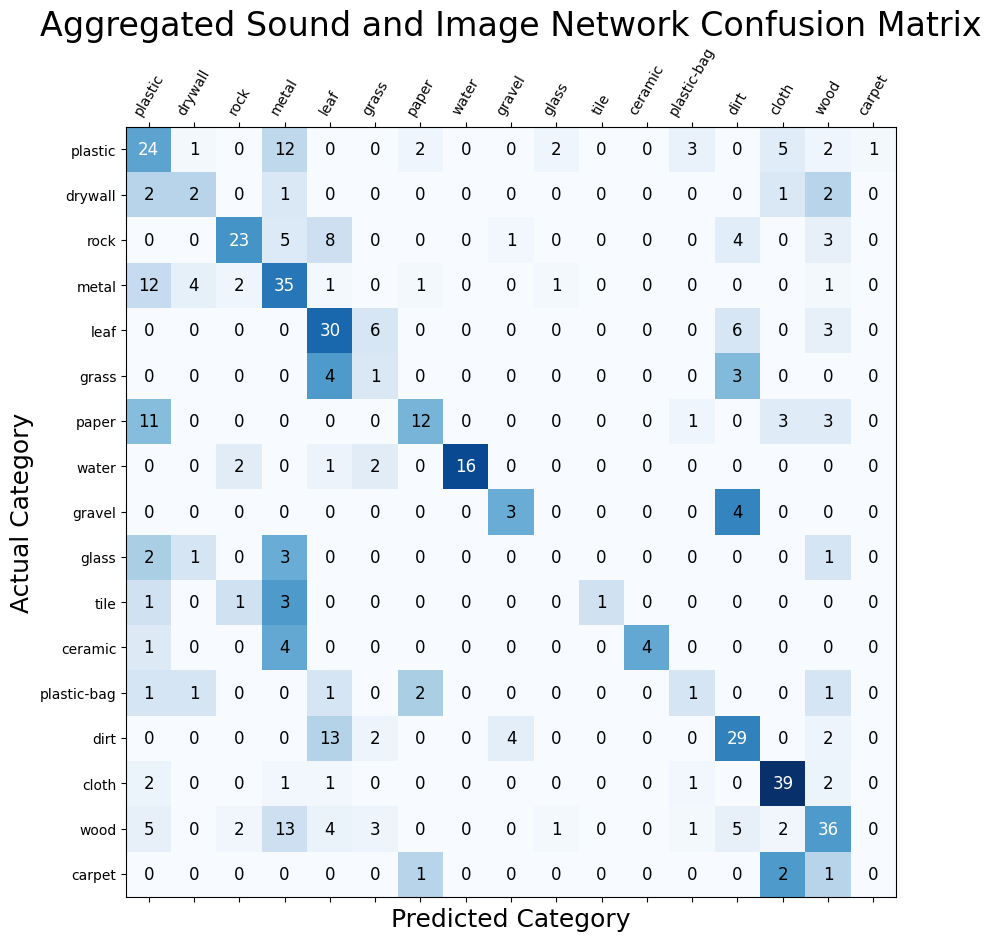

In [ ]:
plot_confusion_matrix(test_actual_labels, test_labels_yours_fcagg)

## Line Plots of Validation Performance

In [ ]:
with open(f'{save_dir}/fcagg_val_history.txt', 'r') as f:
  fcagg_acc = f.read()
  fcagg_acc = fcagg_acc.split("\n")

  fcagg_acc = [float(id[fcagg_acc[i].index("0"): fcagg_acc[i].index(",")]) for id in fcagg_acc if len(id)] # all of the video ids that are part of this dataset split

print(fcagg_acc)

[0.2768, 0.4521, 0.5254, 0.5373, 0.6232, 0.6542, 0.7085, 0.6923, 0.7796, 0.793, 0.8042, 0.85, 0.8775, 0.888, 0.8944, 0.912, 0.8937, 0.9261, 0.9366, 0.9373, 0.9401, 0.9373, 0.9535, 0.9514, 0.9507]


In [ ]:
with open(f'{save_dir}/image_val_history.txt', 'r') as f:
  image_acc = f.read()
  image_acc = image_acc.split("\n")

  image_acc = [float(id[image_acc[i].index("0"): image_acc[i].index(",")]) for id in image_acc if len(id)] # all of the video ids that are part of this dataset split

print(image_acc)

[0.3873, 0.5063, 0.5493, 0.6092, 0.6437, 0.6768, 0.6852, 0.7169, 0.7317, 0.7437, 0.7458, 0.7401, 0.7493, 0.7549, 0.7592, 0.7634, 0.7669, 0.757, 0.7549, 0.7606, 0.762, 0.7648, 0.7641, 0.7606, 0.7641]


In [ ]:
with open(f'{save_dir}/sound_val_history.txt', 'r') as f:
  sound_acc = f.read()
  sound_acc = sound_acc.split("\n")

  sound_acc = [float(id[sound_acc[i].index("0"): sound_acc[i].index(",")]) for id in sound_acc if len(id)] # all of the video ids that are part of this dataset split

print(sound_acc)

[0.3908, 0.4049, 0.5176, 0.5768, 0.6197, 0.6218, 0.6697, 0.7345, 0.7901, 0.807, 0.8141, 0.8458, 0.907, 0.8704, 0.931, 0.9359, 0.9458, 0.962, 0.962, 0.9782, 0.9852, 0.9866, 0.9908, 0.9986, 0.9951]


In [ ]:
epochs = [i + 1 for i in range(len(sound_acc))]

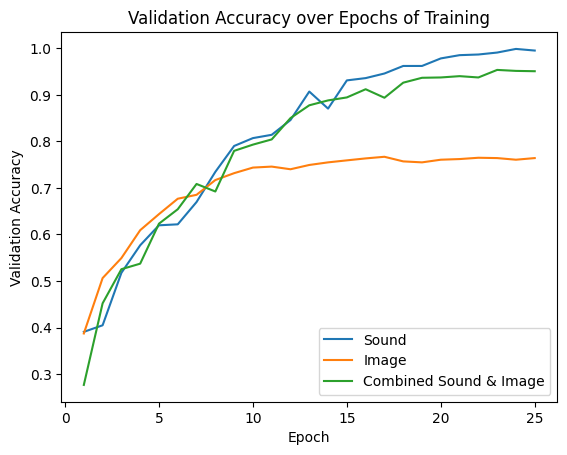

In [ ]:
plt.plot(epochs, sound_acc, label='Sound');
plt.plot(epochs, image_acc, label='Image');
plt.plot(epochs, fcagg_acc, label='Combined Sound & Image');
plt.legend();
plt.xlabel('Epoch');
plt.ylabel('Validation Accuracy');
plt.title('Validation Accuracy over Epochs of Training')
# plt.savefig(f'{data_dir}/validation_accuracies.png')
plt.show();